# Section 0 问题描述与完成项目流程

## 1. 问题描述


<img src="default.png" width="20%"></img>

在该项目中，你将使用强化学习算法，实现一个自动走迷宫机器人。

1. 如上图所示，智能机器人显示在右上角。在我们的迷宫中，有陷阱（红色炸弹）及终点（蓝色的目标点）两种情景。机器人要尽量避开陷阱、尽快到达目的地。
2. 小车可执行的动作包括：向上走 `u`、向右走 `r`、向下走 `d`、向左走 `l`。
3. 执行不同的动作后，根据不同的情况会获得不同的奖励，具体而言，有以下几种情况。
    - 撞到墙壁：-10
    - 走到终点：50
    - 走到陷阱：-30
    - 其余情况：-0.1
4. 我们需要通过修改 `robot.py` 中的代码，来实现一个 Q Learning 机器人，实现上述的目标。

## 2. 完成项目流程

1. 配置环境，使用 `envirnment.yml` 文件配置名为 `robot-env` 的 conda 环境，具体而言，你只需转到当前的目录，在命令行/终端中运行如下代码，稍作等待即可。
```
conda env create -f envirnment.yml
```
安装完毕后，在命令行/终端中运行 `source activate robot-env`（Mac/Linux 系统）或 `activate robot-env`（Windows 系统）激活该环境。

2. 阅读 `main.ipynb` 中的指导完成项目，并根据指导修改对应的代码，生成、观察结果。
3. 导出代码与报告，上传文件，提交审阅并优化。
---

---

# Section 1 算法理解


## 1. 1 强化学习总览

强化学习作为机器学习算法的一种，其模式也是让智能体在“训练”中学到“经验”，以实现给定的任务。但不同于监督学习与非监督学习，在强化学习的框架中，我们更侧重通过智能体与环境的**交互**来学习。通常在监督学习和非监督学习任务中，智能体往往需要通过给定的训练集，辅之以既定的训练目标（如最小化损失函数），通过给定的学习算法来实现这一目标。然而在强化学习中，智能体则是通过其与环境交互得到的奖励进行学习。这个环境可以是虚拟的（如虚拟的迷宫），也可以是真实的（自动驾驶汽车在真实道路上收集数据）。


在强化学习中有五个核心组成部分，它们分别是：**环境（Environment）**、**智能体（Agent）**、**状态（State）**、**动作（Action）**和**奖励（Reward）**。在某一时间节点 $t$：
    
- 智能体在从环境中感知其所处的状态 $s_t$
- 智能体根据某些准则选择动作 $a_t$
- 环境根据智能体选择的动作，向智能体反馈奖励 $r_{t+1}$

通过合理的学习算法，智能体将在这样的问题设置下，成功学到一个在状态 $s_t$ 选择动作 $a_t$ 的策略 $\pi (s_t) = a_t$。

---

**问题 1**：请参照如上的定义，描述出 “机器人走迷宫这个问题” 中强化学习五个组成部分对应的实际对象：

- **环境** : 迷宫, 一个grid spacce. 在’1.问题描述‘下是一个为一4x4的平面网格。实际迷宫大小可变，4x4, 16x16, 5x8， 迷宫大小对算法的perfromacne有很大的影响。环境对Agent的performance有很大的影响，影响因素主要有：迷宫的大小，墙的位置，陷阱的数量，陷阱的位置，终点位置等。观察到的一个有趣的现象是，如果到达终点的唯一通道被陷阱阻挡，在有限的尝试次数中(epoch),Agent无法到达终点；而在较小的迷宫中，也观察到曾有agent走过陷阱到达目的情况。
- **状态** : 机器人当前所在的位置，在一个n x n的平面上，机器人可能有n x n 种不同的状态。在本程序中，状态由坐标元组表示，例如 (9, 15) 代表agent在每十行最后一列。实际上，由于迷宫的布局，greedy策略和有限尝试次数的限制，机器人Agent不会经过所有的状态。值的注意的是，状态是针对于具体的迷宫而言的，同样大小的迷宫，由于布局的不同，其状态值各自独立。
- **动作** : 四种，向上走 `u`、向右走 `r`、向下走 `d`、向左走 `l`
- **奖励** : 
    - 撞到墙壁：-10
    - 走到终点：50
    - 走到陷阱：-30
    - 其余情况：-0.1

$$T(s^{'}, a, s) = P(s^{'}|a,s)$$


---

## 1.2 计算 Q 值 

在我们的项目中，我们要实现基于 Q-Learning 的强化学习算法。Q-Learning 是一个值迭代（Value Iteration）算法。与策略迭代（Policy Iteration）算法不同，值迭代算法会计算每个”状态“或是”状态-动作“的值（Value）或是效用（Utility），然后在执行动作的时候，会设法最大化这个值。因此，对每个状态值的准确估计，是我们值迭代算法的核心。通常我们会考虑**最大化动作的长期奖励**，即不仅考虑当前动作带来的奖励，还会考虑动作长远的奖励。

在 Q-Learning 算法中，我们把这个长期奖励记为 Q 值，我们会考虑每个 ”状态-动作“ 的 Q 值，具体而言，它的计算公式为：

$$
q(s_{t},a) = R_{t+1} + \gamma \times\max_a q(a,s_{t+1})
$$

也就是对于当前的“状态-动作” $(s_{t},a)$，我们考虑执行动作 $a$ 后环境给我们的奖励 $R_{t+1}$，以及执行动作 $a$ 到达 $s_{t+1}$后，执行任意动作能够获得的最大的Q值 $\max_a q(a,s_{t+1})$，$\gamma$ 为折扣因子。

不过一般地，我们使用更为保守地更新 Q 表的方法，即引入松弛变量 $alpha$，按如下的公式进行更新，使得 Q 表的迭代变化更为平缓。

$$
q(s_{t},a) = (1-\alpha) \times q(s_{t},a) + \alpha \times(R_{t+1} + \gamma \times\max_a q(a,s_{t+1}))
$$



---
<img src="default2.png" width="20%"></img>

**问题 2**：根据已知条件求 $q(s_{t},a)$，在如下模板代码中的空格填入对应的数字即可。


已知：如上图，机器人位于 $s_1$，行动为 `u`，行动获得的奖励与题目的默认设置相同。在 $s_2$ 中执行各动作的 Q 值为：`u`: -24，`r`: -13，`d`: -0.29、`l`: +40，$\gamma$ 取0.9。


$$
\begin{align}
q(s_{t},a) & = R_{t+1} + \gamma \times\max_a q(a,s_{t+1}) \\
 & =(-0.1) + (0.9)*(40) \\
 & =(35.9)
\end{align}
$$


---

## 1.3 如何选择动作

在强化学习中，「探索-利用」问题是非常重要的问题。具体来说，根据上面的定义，我们会尽可能地让机器人在每次选择最优的决策，来最大化长期奖励。但是这样做有如下的弊端：
1. 在初步的学习中，我们的 Q 值会不准确，如果在这个时候都按照 Q 值来选择，那么会造成错误。
2. 学习一段时间后，机器人的路线会相对固定，则机器人无法对环境进行有效的探索。

因此我们需要一种办法，来解决如上的问题，增加机器人的探索。由此我们考虑使用 epsilon-greedy 算法，即在小车选择动作的时候，以一部分的概率随机选择动作，以一部分的概率按照最优的 Q 值选择动作。同时，这个选择随机动作的概率应当随着训练的过程逐步减小。

---

**问题 3**：在如下的代码块中，实现 epsilon-greedy 算法的逻辑，并运行测试代码。

In [1]:
import random
import numpy as np
actions = ['u','r','d','l']
qline = {'u':1.2, 'r':-2.1, 'd':-24.5, 'l':27}
epsilon = 0.3 # 以0.3的概率进行随机选择

def choose_action(epsilon):
    
    action = None
    if random.random() < epsilon: # 以某一概率
#         pass # 实现对动作的随机选择
        action = random.choice(actions)
    else: 
#         pass # 否则选择具有最大 Q 值的动作
        action = max(qline, key = qline.get)
    return action


def test_choose_action():
    for i in np.arange(10):
        print(choose_action(epsilon))
test_choose_action()

l
l
l
l
l
u
r
d
u
u


---

---

# Section 2 代码实现

## 2.1. `Maze` 类理解

我们首先引入了迷宫类 `Maze`，这是一个非常强大的函数，它能够根据你的要求随机创建一个迷宫，或者根据指定的文件，读入一个迷宫地图信息。

1. 使用 `Maze("file_name")` 根据指定文件创建迷宫，或者使用 `Maze(maze_size=(height,width))` 来随机生成一个迷宫。
2. 使用 `trap_number` 参数，在创建迷宫的时候，设定迷宫中陷阱的数量。
3. 直接键入迷宫变量的名字按回车，展示迷宫图像（如 `g=Maze("xx.txt")`，那么直接输入 `g` 即可。
4. 建议生成的迷宫尺寸，长在 6~12 之间，宽在 10～12 之间。

---

**问题 4**：在如下的代码块中，创建你的迷宫并展示。

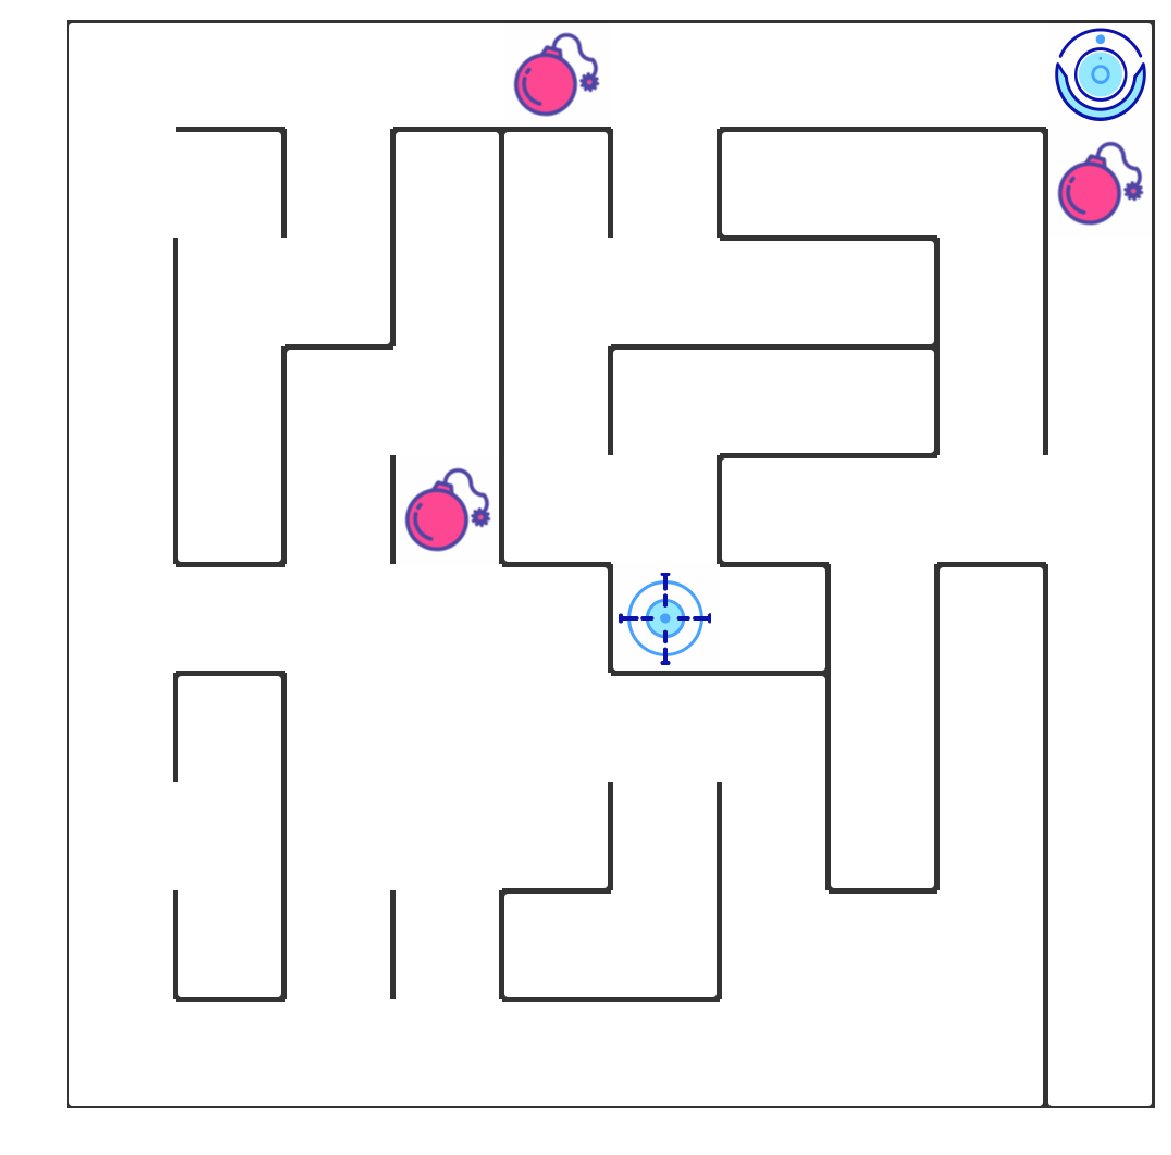

Maze of size (10, 10)

In [2]:
from Maze import Maze
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## todo: 创建迷宫并展示
mz = Maze(maze_size = (10, 10), trap_number = 3)
# print(mz.sense_robot())
# print(mz.move_robot('d'))
# print(mz.sense_robot())
mz

---

你可能已经注意到，在迷宫中我们已经默认放置了一个机器人。实际上，我们为迷宫配置了相应的 API，来帮助机器人的移动与感知。其中你随后会使用的两个 API 为 `maze.sense_robot()` 及 `maze.move_robot()`。

1. `maze.sense_robot()` 为一个无参数的函数，输出机器人在迷宫中目前的位置。
2. `maze.move_robot(direction)` 对输入的移动方向，移动机器人，并返回对应动作的奖励值。

---

**问题 5**：随机移动机器人，并记录下获得的奖励，展示出机器人最后的位置。

(0, 5)
[-0.1, -0.1, -0.1, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -0.1]
['l', 'l', 'l', 'd', 'u', 'd', 'u', 'd', 'u', 'l']


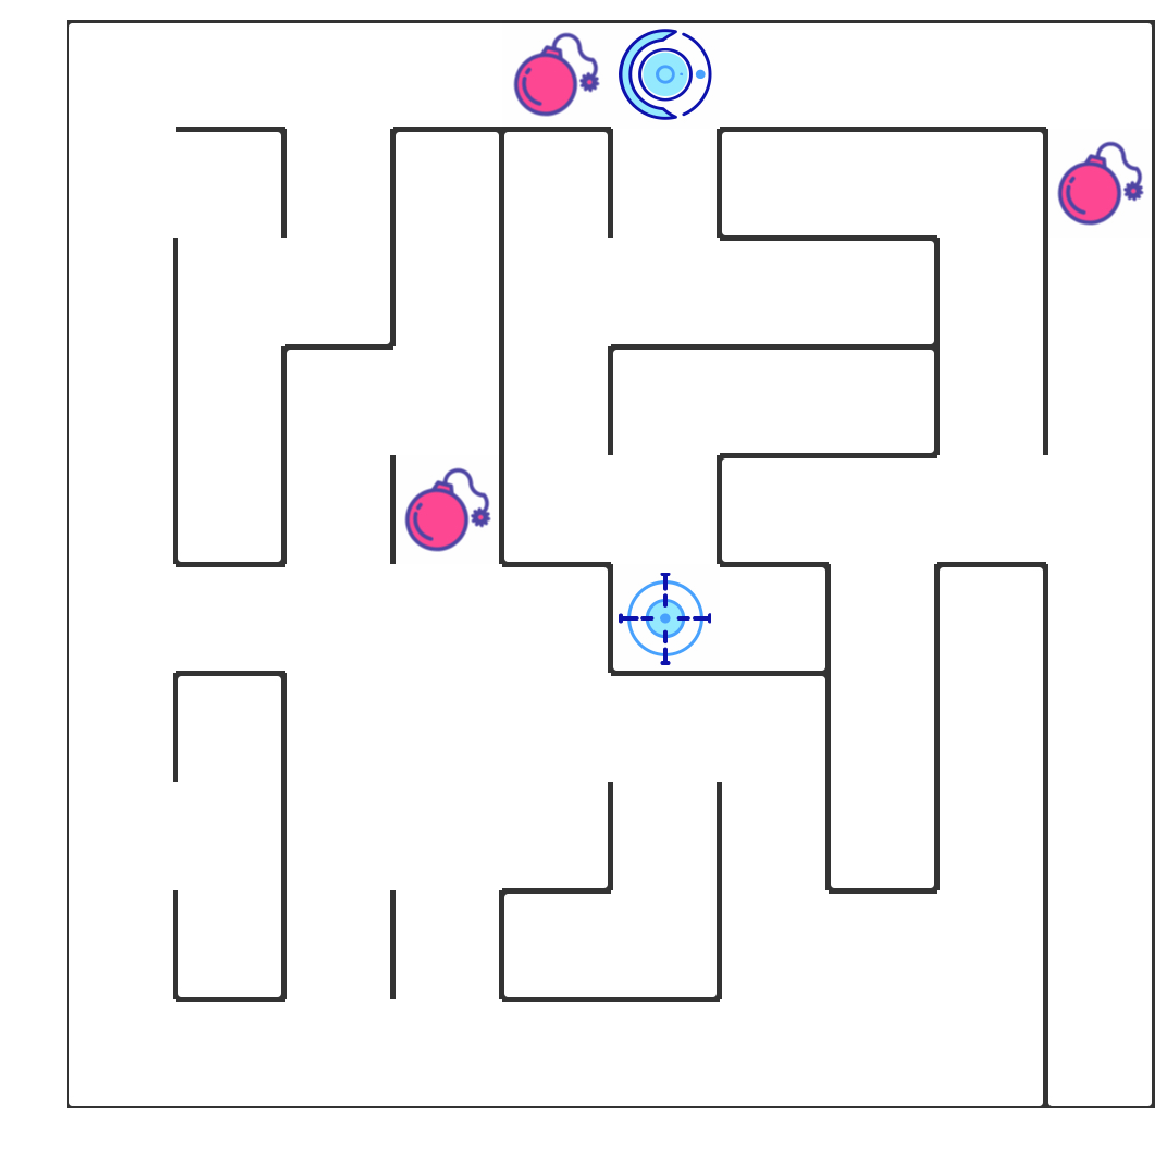

Maze of size (10, 10)

In [3]:
rewards = []
action_steps = []
## 循环、随机移动机器人10次，记录下奖励
for i in range(10):
    a = random.choice(actions)
#     print(a)
    action_steps.append(a)
    rewards.append(mz.move_robot(a))

## 输出机器人最后的位置
print(mz.sense_robot())
print(rewards)
print(action_steps)

## 打印迷宫，观察机器人位置
mz

## 2.2. `Robot` 类实现

`Robot` 类是我们需要重点实现的部分。在这个类中，我们需要实现诸多功能，以使得我们成功实现一个强化学习智能体。总体来说，之前我们是人为地在环境中移动了机器人，但是现在通过实现 `Robot` 这个类，机器人将会自己移动。通过实现学习函数，`Robot` 类将会学习到如何选择最优的动作，并且更新强化学习中对应的参数。

首先 `Robot` 有多个输入，其中 `alpha=0.5, gamma=0.9, epsilon0=0.5` 表征强化学习相关的各个参数的默认值，这些在之前你已经了解到，`Maze` 应为机器人所在迷宫对象。

随后观察 `Robot.update` 函数，它指明了在每次执行动作时，`Robot` 需要执行的程序。按照这些程序，各个函数的功能也就明了了。

最后你需要实现 `Robot.py` 代码中的8段代码，他们都在代码中以 `#TODO` 进行标注，你能轻松地找到他们。

---

**问题 6**：实现 `Robot.py` 中的8段代码，并运行如下代码检查效果（记得将 `maze` 变量修改为你创建迷宫的变量名）。



('r', -0.1)


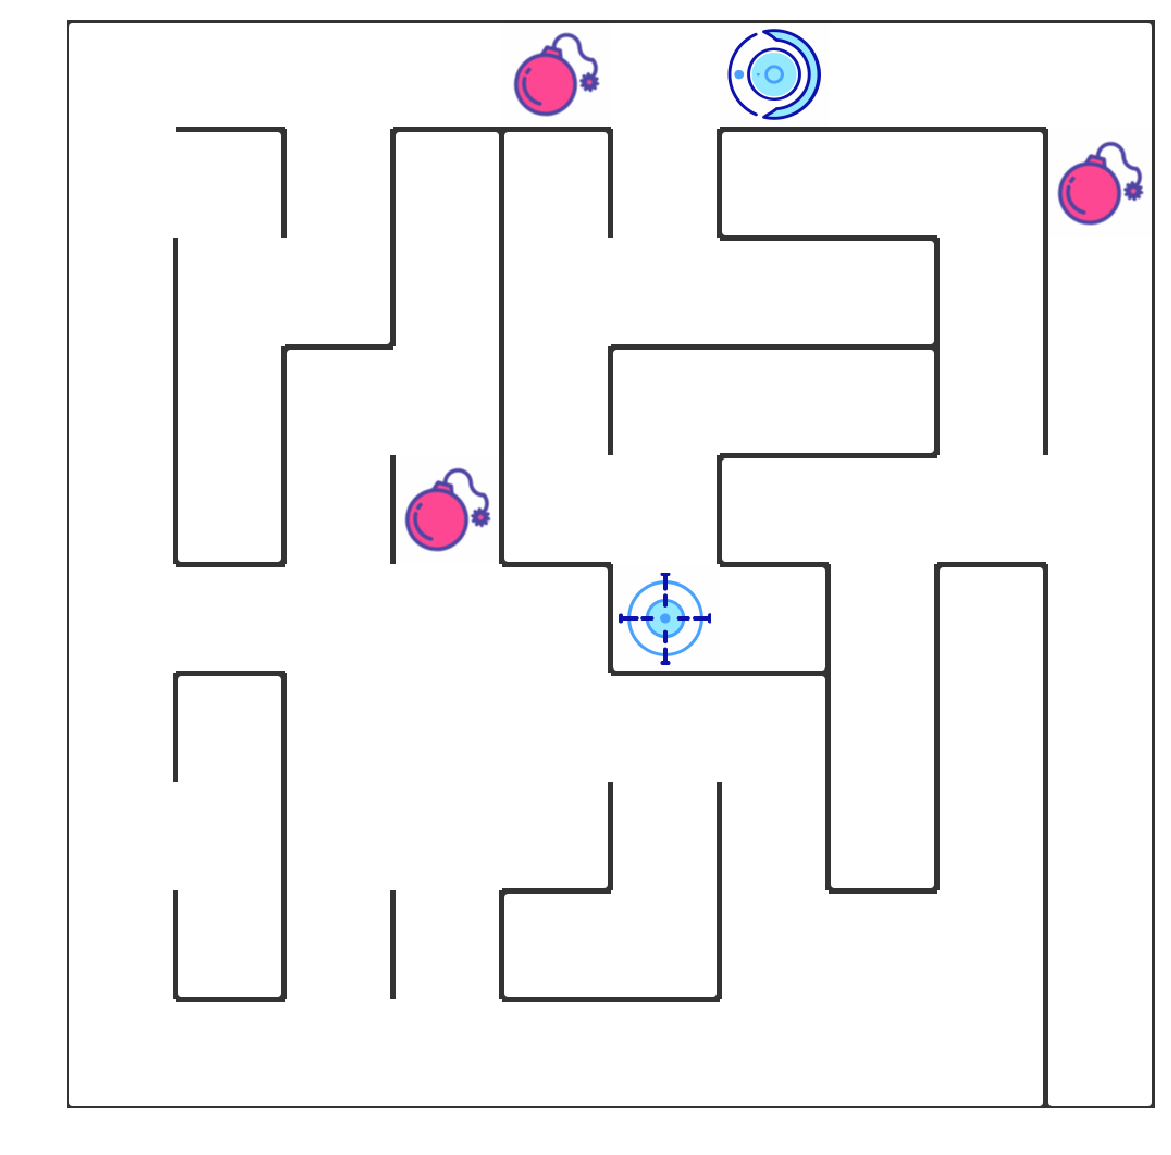

Maze of size (10, 10)

In [4]:
from Robot import Robot
robot = Robot(mz) # 记得将 maze 变量修改为你创建迷宫的变量名
robot.set_status(learning=True,testing=False)
print(robot.update())

mz

---

## 2.3 用 `Runner` 类训练 Robot

在实现了上述内容之后，我们就可以开始对我们 `Robot` 进行训练并调参了。我们为你准备了又一个非常棒的类 `Runner`，来实现整个训练过程及可视化。使用如下的代码，你可以成功对机器人进行训练。并且你会在当前文件夹中生成一个名为 `filename` 的视频，记录了整个训练的过程。通过观察该视频，你能够发现训练过程中的问题，并且优化你的代码及参数。

---

**问题 7**：尝试利用下列代码训练机器人，并进行调参。可选的参数包括：

- 训练参数
    - 训练次数 `epoch`
- 机器人参数：
    - `epsilon0` (epsilon 初值)
    - `epsilon`衰减（可以是线性、指数衰减，可以调整衰减的速度），你需要在 Robot.py 中调整
    - `alpha`
    - `gamma`
- 迷宫参数:
    - 迷宫大小
    - 迷宫中陷阱的数量

In [5]:
## 可选的参数：
epoch = 100

epsilon0 = 0.5
alpha = 0.5
gamma = 0.9

maze_size = (16,16)
trap_number = 6

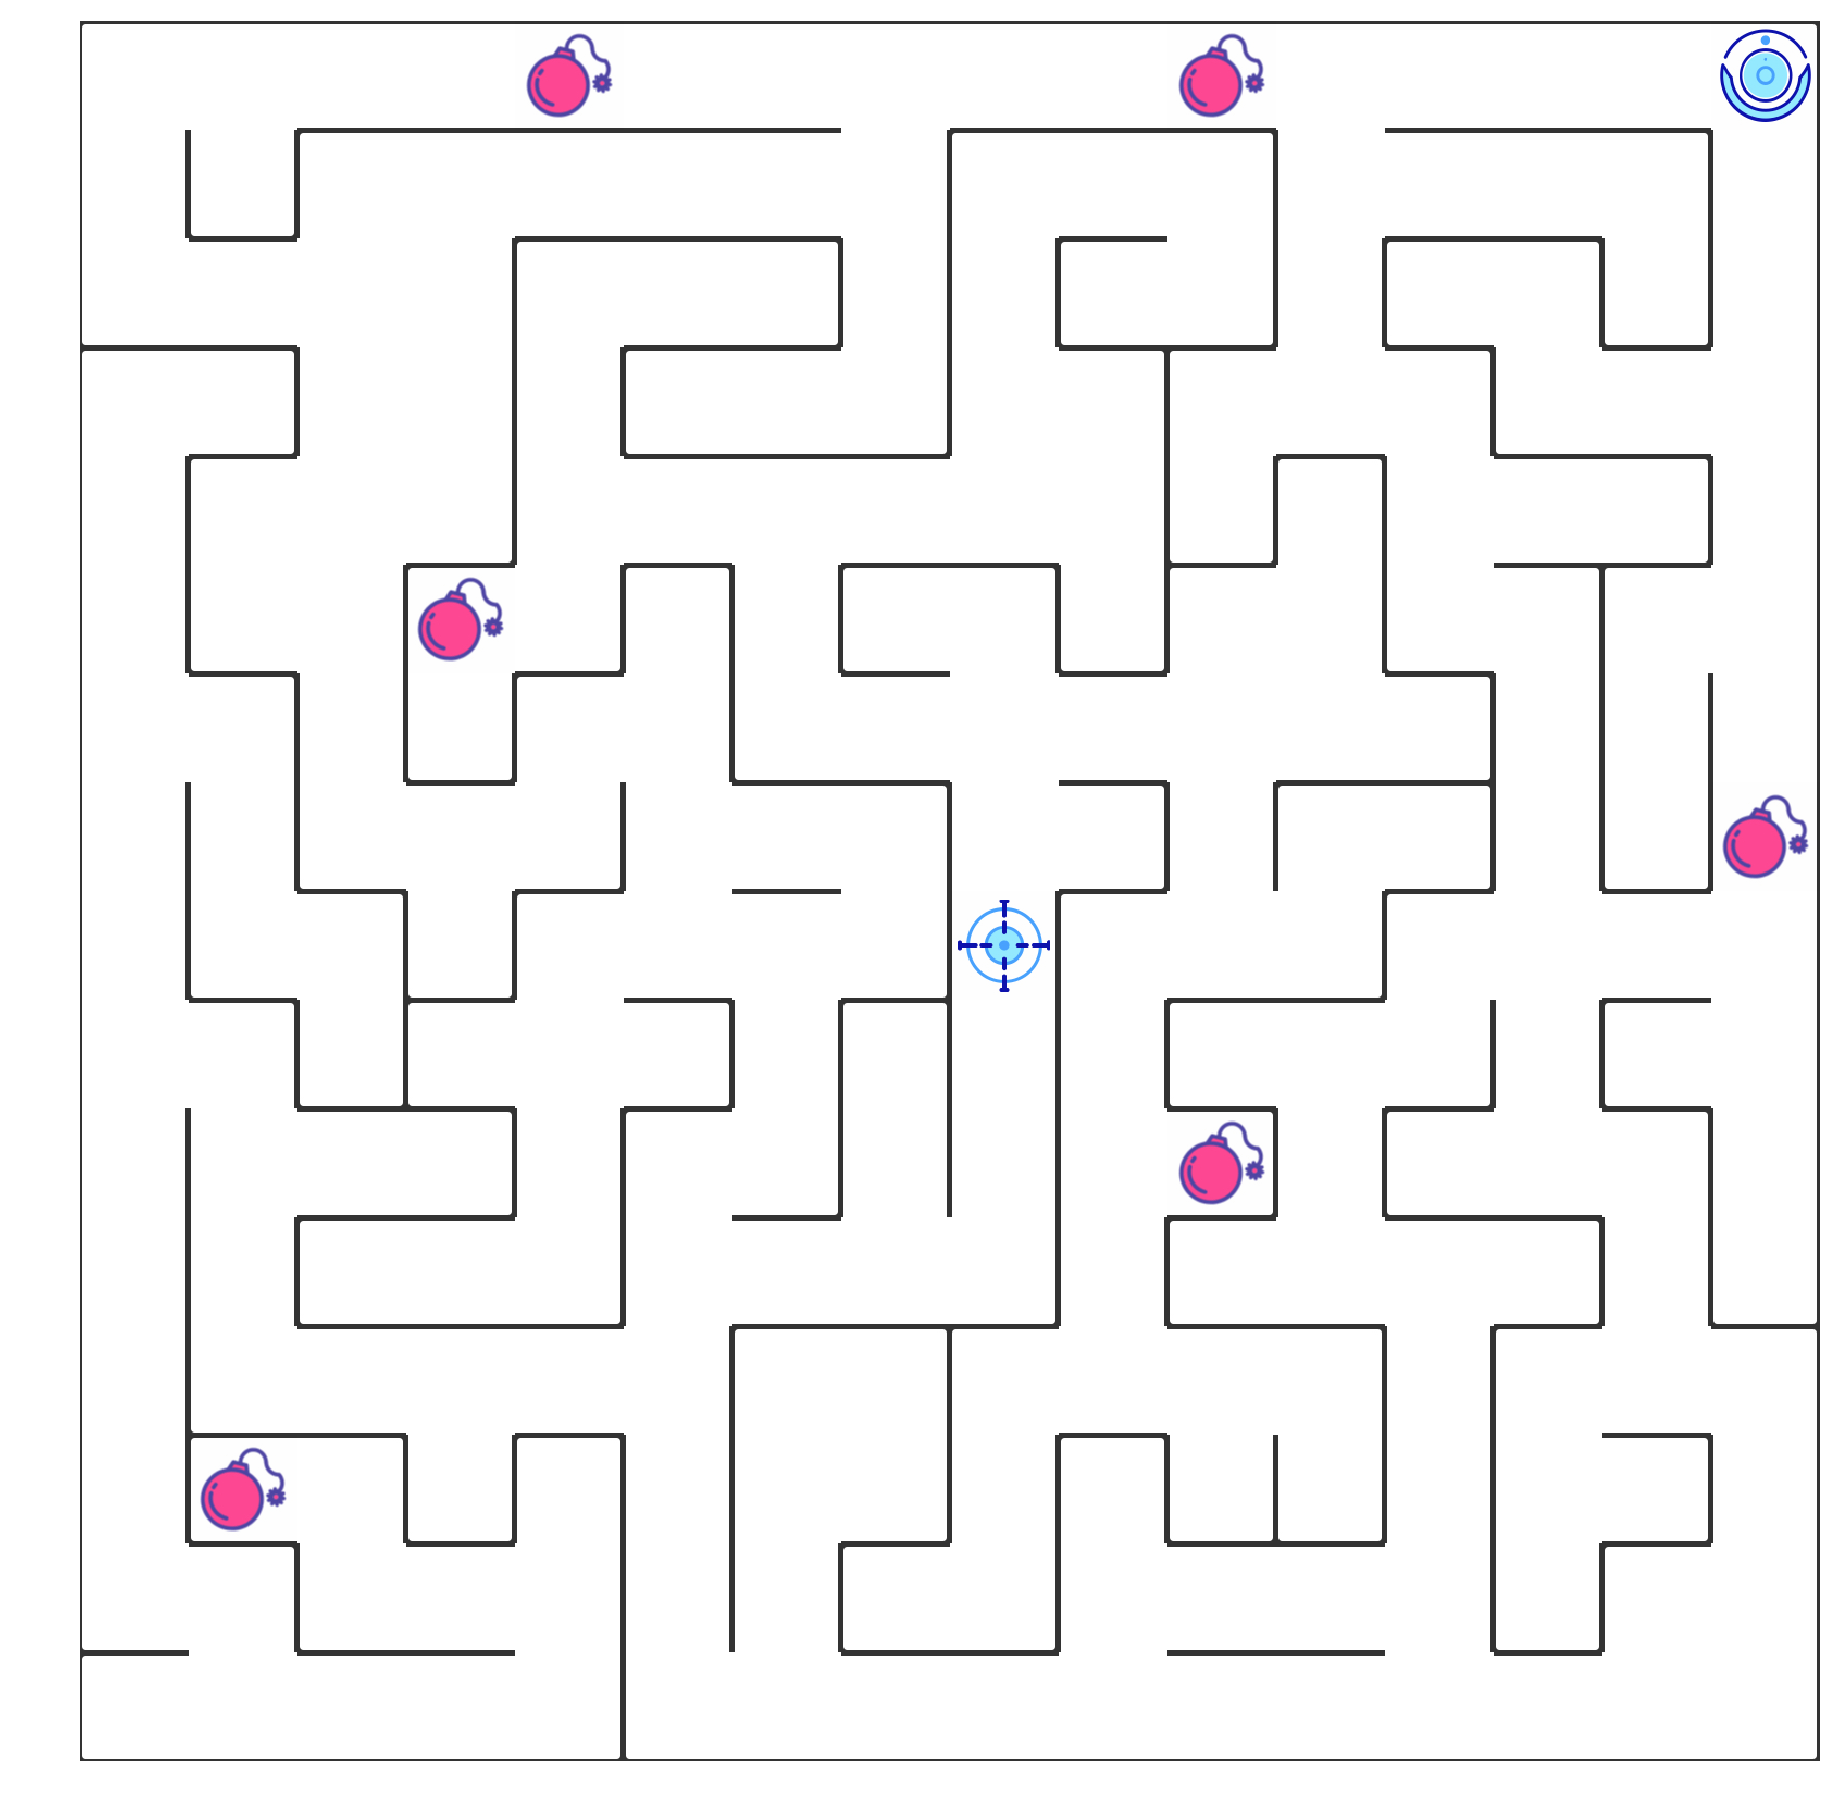

Maze of size (16, 16)

In [6]:
g = Maze(maze_size=maze_size,trap_number=trap_number)
g

q(st,a)=(1−α)×q(st,a)+α×(Rt+1+γ×maxaq(a,st+1))

In [7]:
from Runner import Runner

# g = Maze(maze_size=maze_size,trap_number=trap_number)
r = Robot(g,alpha=alpha, epsilon0=epsilon0, gamma=gamma)
r.set_status(learning=True)

runner = Runner(r, g)
runner.run_training(epoch, display_direction=True)
# runner.generate_movie(filename = "final1.mp4") # 你可以注释该行代码，加快运行速度，不过你就无法观察到视频了。

In [8]:
r_alpha_dot_95 = Robot(g,alpha=0.95, epsilon0=epsilon0, gamma=gamma)
r_alpha_dot_95.set_status(learning=True)

runner_alpha_dot_95 = Runner(r_alpha_dot_95, g)
runner_alpha_dot_95.run_training(epoch, display_direction=True)

In [9]:
r_alpha_dot_85 = Robot(g,alpha=0.85, epsilon0=epsilon0, gamma=gamma)
r_alpha_dot_85.set_status(learning=True)

runner_alpha_dot_85 = Runner(r_alpha_dot_85, g)
runner_alpha_dot_85.run_training(epoch, display_direction=True)

In [10]:
r_alpha_dot_7 = Robot(g,alpha=0.7, epsilon0=epsilon0, gamma=gamma)
r_alpha_dot_7.set_status(learning=True)

runner_alpha_dot_7 = Runner(r_alpha_dot_7, g)
runner_alpha_dot_7.run_training(epoch, display_direction=True)

In [11]:
r_alpha_dot_2 = Robot(g,alpha=0.2, epsilon0=epsilon0, gamma=gamma)
r_alpha_dot_2.set_status(learning=True)

runner_alpha_dot_2 = Runner(r_alpha_dot_2, g)
runner_alpha_dot_2.run_training(epoch, display_direction=True)

In [12]:
r_alpha_dot_02 = Robot(g,alpha=0.02, epsilon0=epsilon0, gamma=gamma)
r_alpha_dot_02.set_status(learning=True)

runner_alpha_dot_02 = Runner(r_alpha_dot_02, g)
runner_alpha_dot_02.run_training(epoch, display_direction=True)

In [13]:
r_alpha_full_1 = Robot(g,alpha=1.0, epsilon0=epsilon0, gamma=gamma)
r_alpha_full_1.set_status(learning=True)

runner_alpha_full_1 = Runner(r_alpha_full_1, g)
runner_alpha_full_1.run_training(epoch, display_direction=True)

---

使用 `runner.plot_results()` 函数，能够打印机器人在训练过程中的一些参数信息。

- Success Times 代表机器人在训练过程中成功的累计次数，这应当是一个累积递增的图像。
- Accumulated Rewards 代表机器人在每次训练 epoch 中，获得的累积奖励的值，这应当是一个逐步递增的图像。
- Running Times per Epoch 代表在每次训练 epoch 中，小车训练的次数（到达终点就会停止该 epoch 转入下次训练），这应当是一个逐步递减的图像。

---

**问题 8**：使用 `runner.plot_results()` 输出训练结果，根据该结果对你的机器人进行分析。

- 指出你选用的参数如何，选用参数的原因。
- 建议你比较不同参数下机器人的训练的情况。
- 训练的结果是否满意，有何改进的计划。

In [14]:
# print(runner.train_robot_statics)

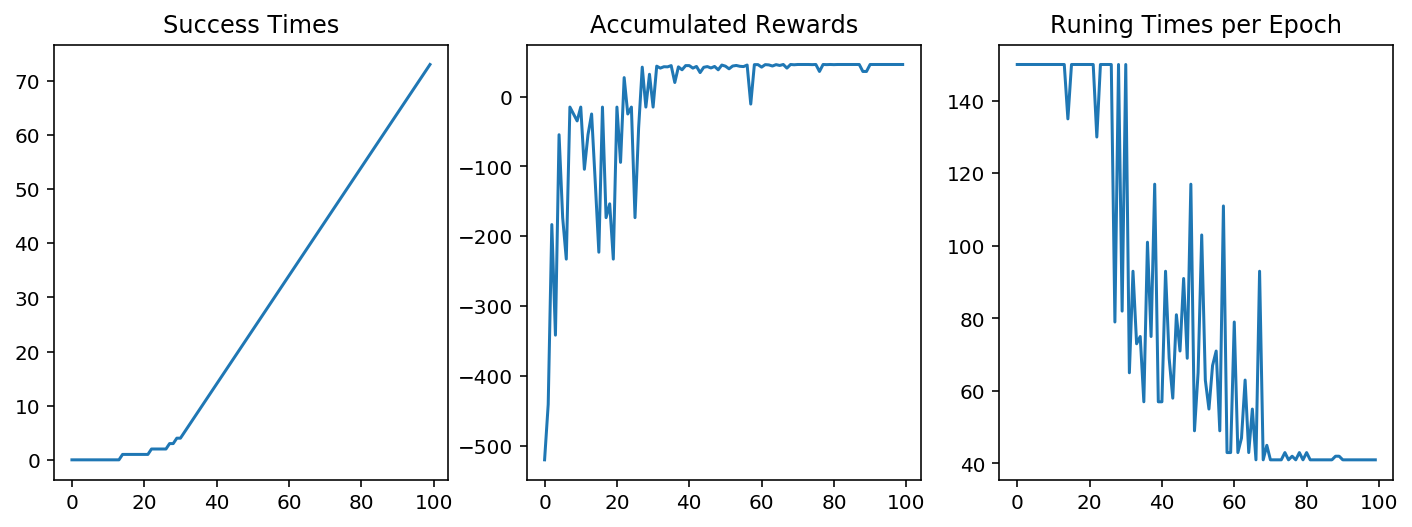

alpha = 1.0



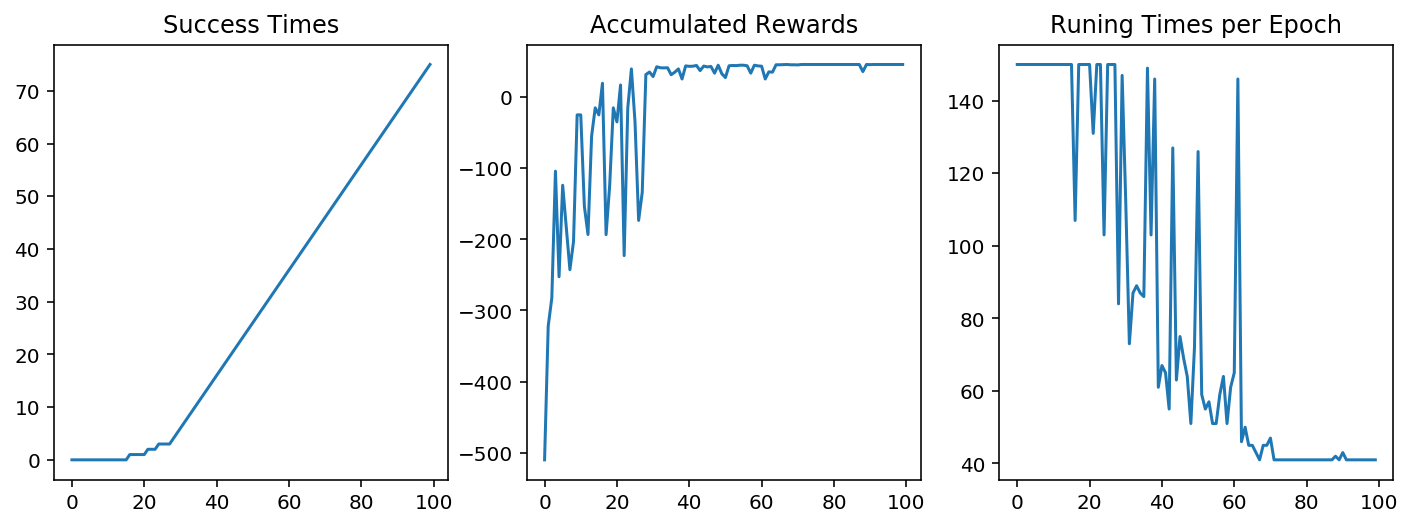

alpha = 0.95



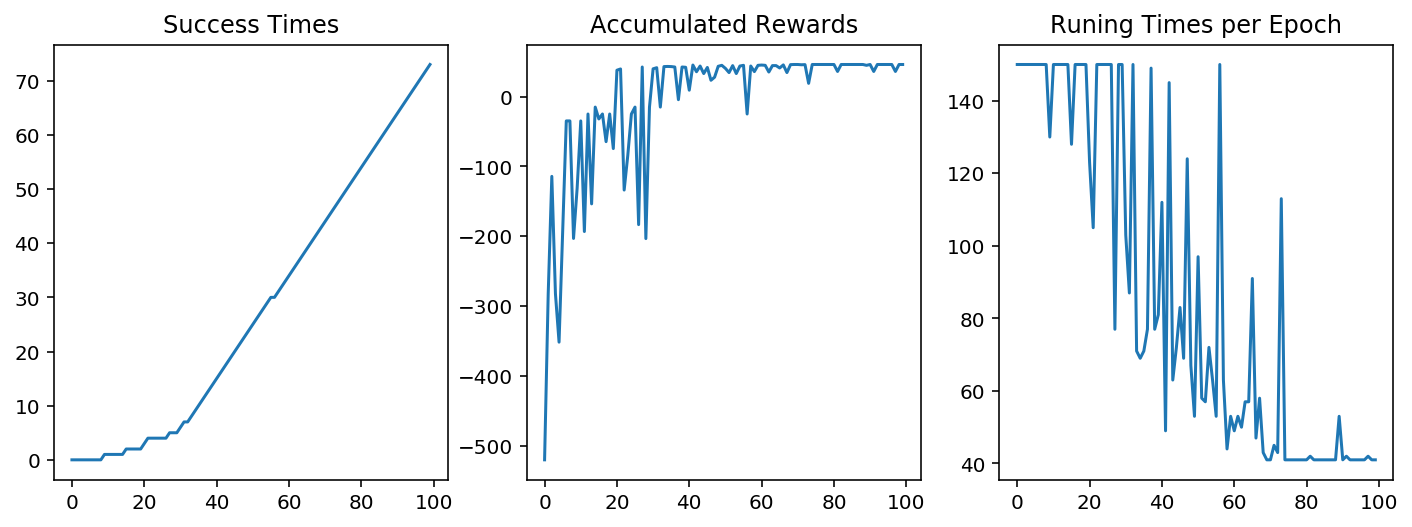

alpha = 0.85



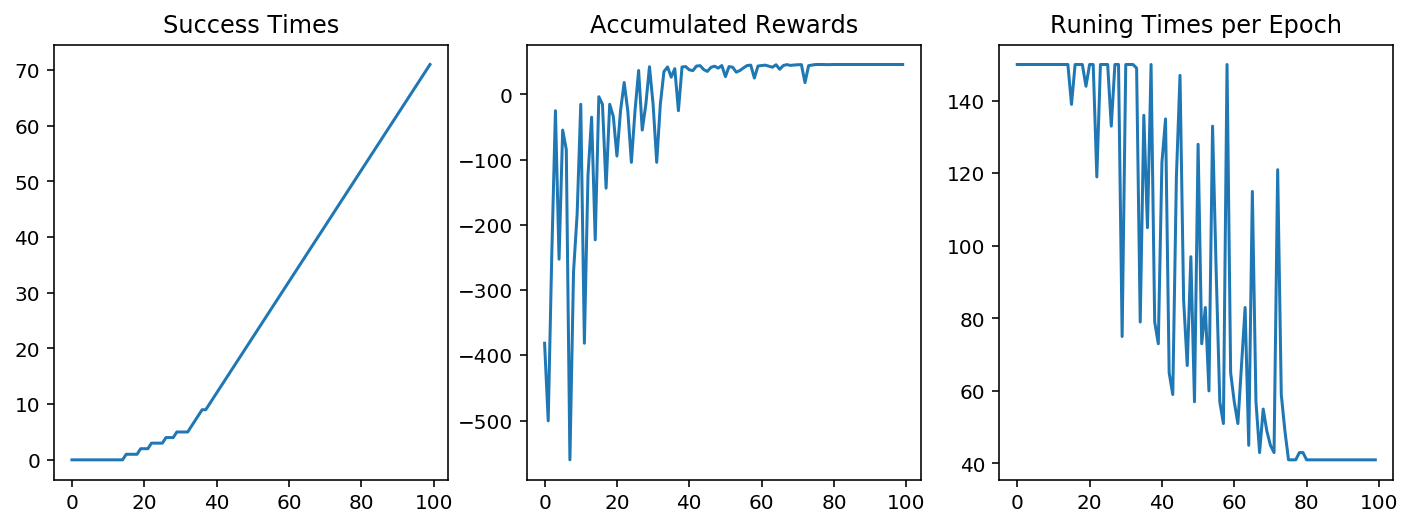

alpha = 0.7



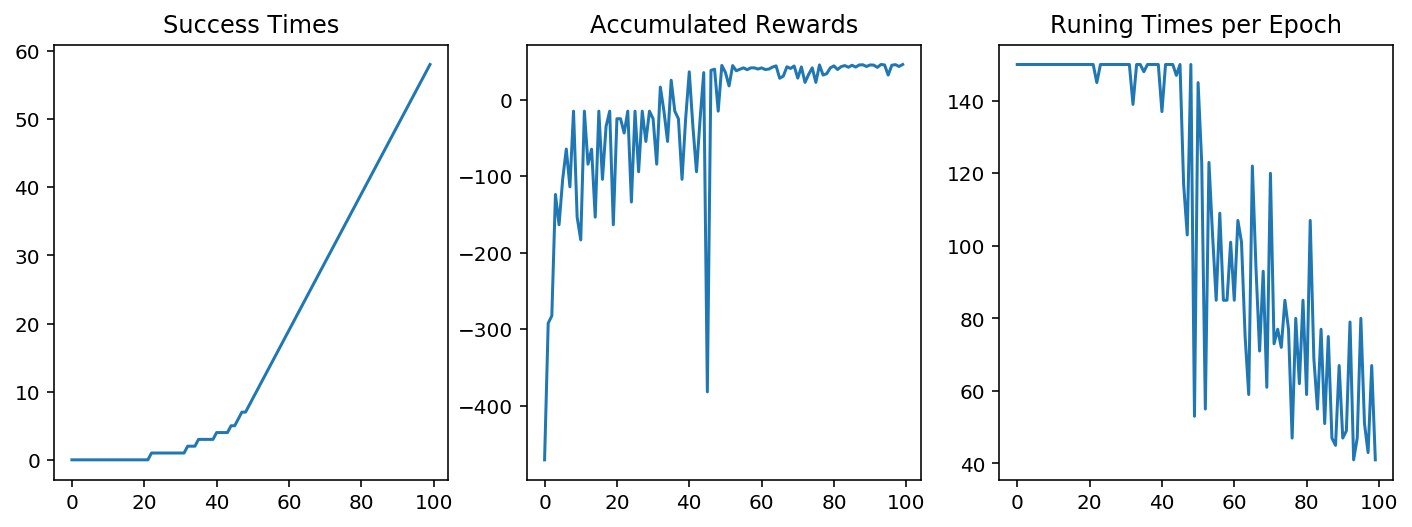

alpha = 0.5



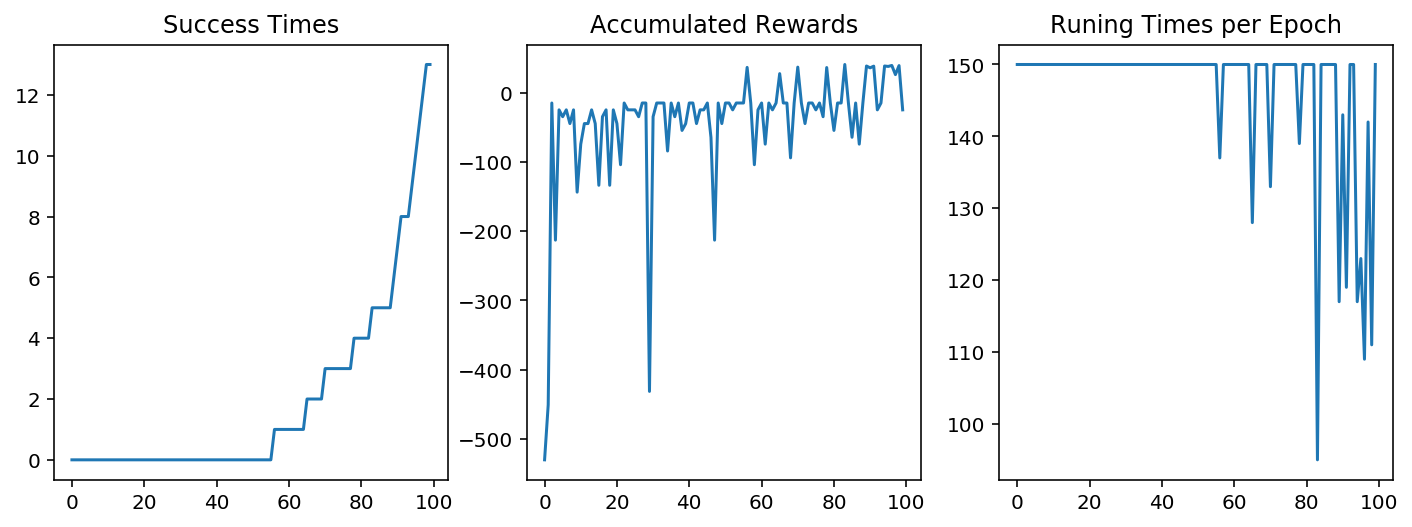

alpha = 0.2



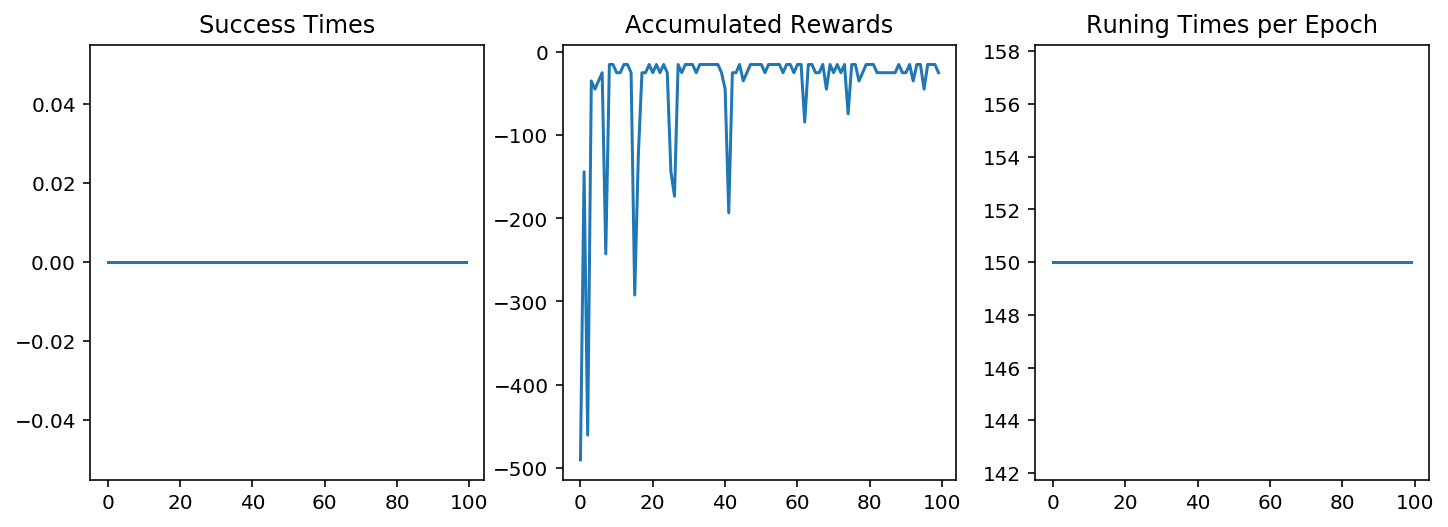

alpha = 0.02



In [15]:
runner_alpha_full_1.plot_results()
print('alpha = 1.0\n')
runner_alpha_dot_95.plot_results()
print('alpha = 0.95\n')
runner_alpha_dot_85.plot_results()
print('alpha = 0.85\n')
runner_alpha_dot_7.plot_results()
print('alpha = 0.7\n')
runner.plot_results()
print('alpha = 0.5\n')
runner_alpha_dot_2.plot_results()
print('alpha = 0.2\n')
runner_alpha_dot_02.plot_results()
print('alpha = 0.02\n')

In [16]:
r_alpha_full_1.Qtable

{(0, 10): {'d': 0.0, 'l': 0.0, 'r': -0.19, 'u': -10.0},
 (0, 11): {'d': 0.1489483767918986,
  'l': -30.0,
  'r': -0.9774716004550608,
  'u': -10.0},
 (0, 12): {'d': -10.0,
  'l': 0.034053539112708725,
  'r': -0.9797244404095546,
  'u': -10.0},
 (0, 13): {'d': -10.0,
  'l': -0.06935181479856214,
  'r': -0.9835767967317393,
  'u': -10.6458134171671},
 (0, 14): {'d': -10.146174969986836,
  'l': -0.16241663331870593,
  'r': -0.9835767967317393,
  'u': -10.0},
 (0, 15): {'d': -0.9852191170585654,
  'l': -0.24617496998683536,
  'r': -10.0,
  'u': -10.0},
 (1, 2): {'d': 0.0, 'l': 0.0, 'r': -0.1, 'u': -10.0},
 (1, 3): {'d': 0.0, 'l': 0.0, 'r': -0.1, 'u': -10.0},
 (1, 4): {'d': 0.0, 'l': 0.0, 'r': -0.1, 'u': -10.0},
 (1, 5): {'d': 0.0, 'l': 0.0, 'r': 0.0, 'u': 0.0},
 (1, 11): {'d': 0.276609307546554,
  'l': -10.0,
  'r': -0.9749684449500675,
  'u': -0.9774716004550608},
 (1, 12): {'d': -10.0,
  'l': -0.9749684449500675,
  'r': -0.9749684449500675,
  'u': -10.0},
 (1, 13): {'d': -10.0,
  'l': -0

## epsilon optimization:

In [17]:
r_alpha_full_1_linear = Robot(g,alpha=1.0, epsilon0=epsilon0, gamma=gamma)
r_alpha_full_1_linear.set_status(learning=True)
r_alpha_full_1_linear.set_epsilon_linear_decay(linear_decay = True)

runner_alpha_full_1_linear = Runner(r_alpha_full_1_linear, g)
runner_alpha_full_1_linear.run_training(epoch, display_direction=True)

In [18]:
r_alpha_full_1_newE0 = Robot(g,alpha=1.0, epsilon0=1, gamma=gamma)
r_alpha_full_1_newE0.set_status(learning=True)
# r_alpha_full_1_newE0.set_epsilon_linear_decay(linear_decay = True)

runner_alpha_full_1_newE0 = Runner(r_alpha_full_1_newE0, g)
runner_alpha_full_1_newE0.run_training(epoch, display_direction=True)

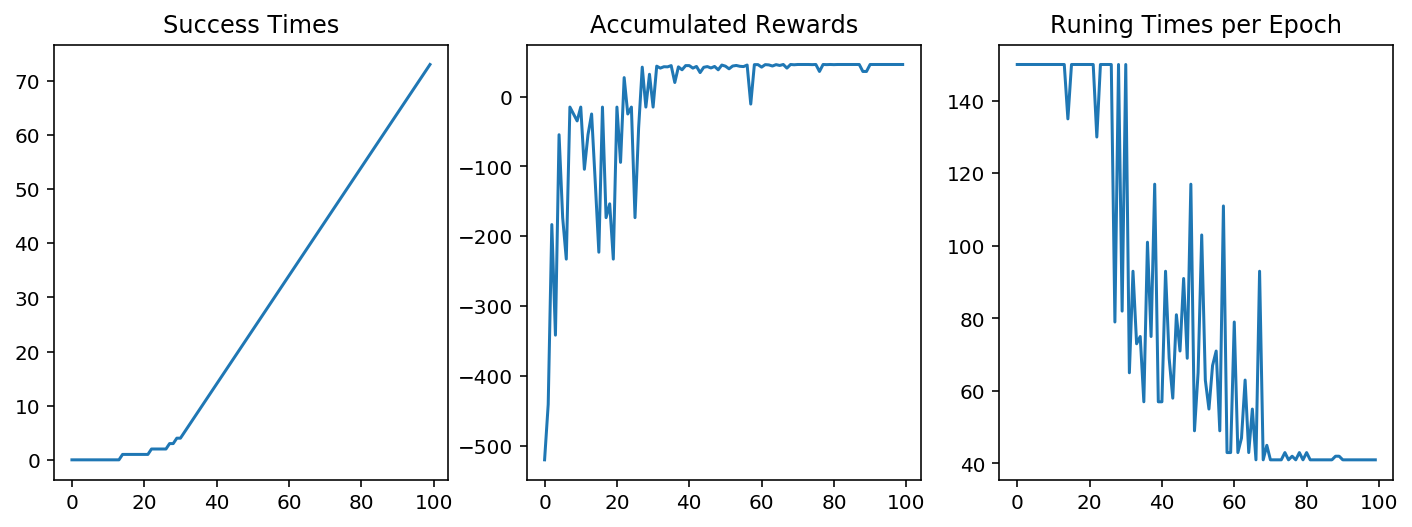

epsilon squre root decay


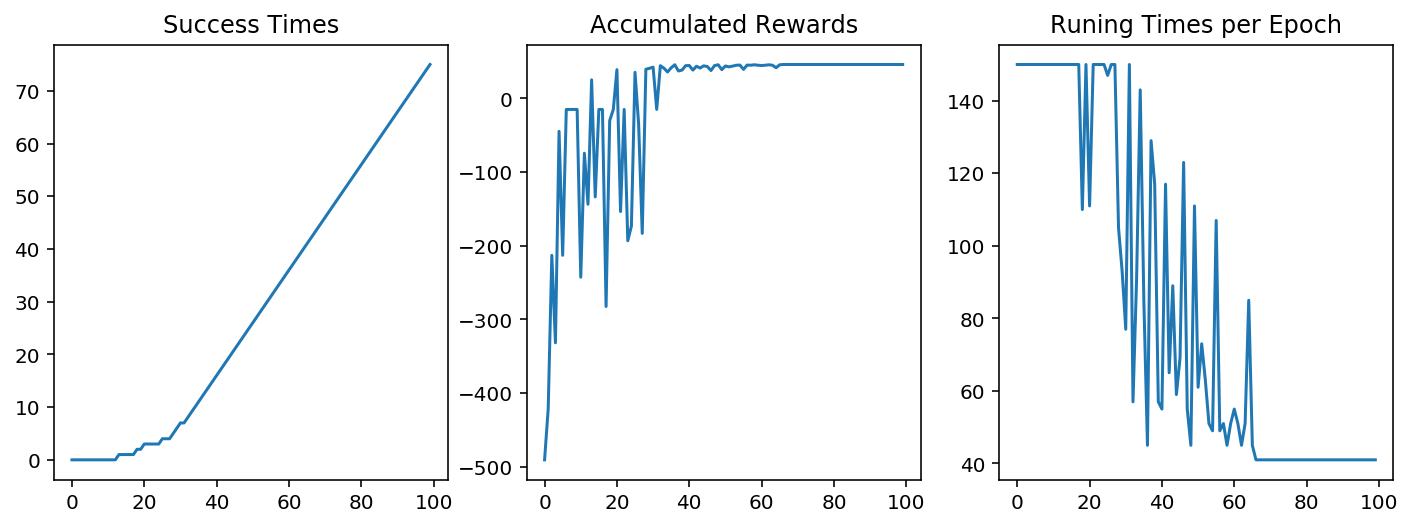

epsilon linear decay


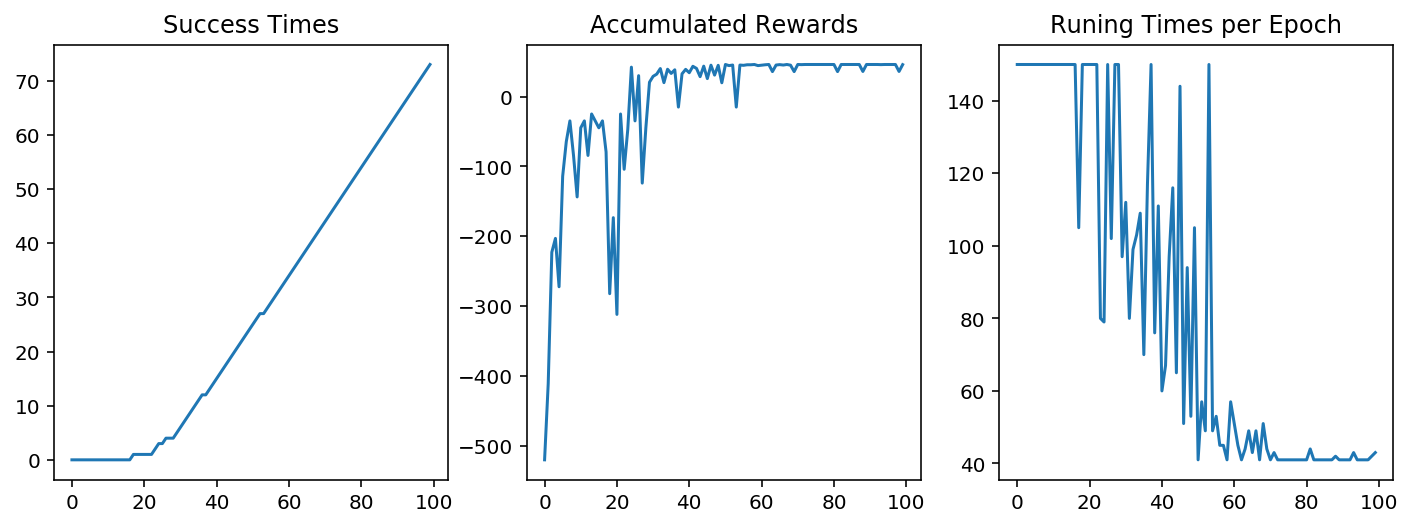

epsilon square root decay with epislon0 = 1


In [19]:
runner_alpha_full_1.plot_results()
print('epsilon squre root decay')
runner_alpha_full_1_linear.plot_results()
print('epsilon linear decay')
runner_alpha_full_1_newE0.plot_results()
print('epsilon square root decay with epislon0 = 1')

## epsilon optimization:
更多的初期探索（前10次均为探索）

In [20]:
r_alpha_full_1_explore_5 = Robot(g,alpha=1.0, epsilon0=epsilon0, gamma=gamma, explicit_exploration_count= 5)
r_alpha_full_1_explore_5.set_status(learning=True)

runner_alpha_full_1_explore_5 = Runner(r_alpha_full_1_explore_5, g)
runner_alpha_full_1_explore_5.run_training(epoch, display_direction=True)


r_alpha_full_1_explore_10 = Robot(g,alpha=1.0, epsilon0=epsilon0, gamma=gamma, explicit_exploration_count= 10)
r_alpha_full_1_explore_10.set_status(learning=True)

runner_alpha_full_1_explore_10 = Runner(r_alpha_full_1_explore_10, g)
runner_alpha_full_1_explore_10.run_training(epoch, display_direction=True)

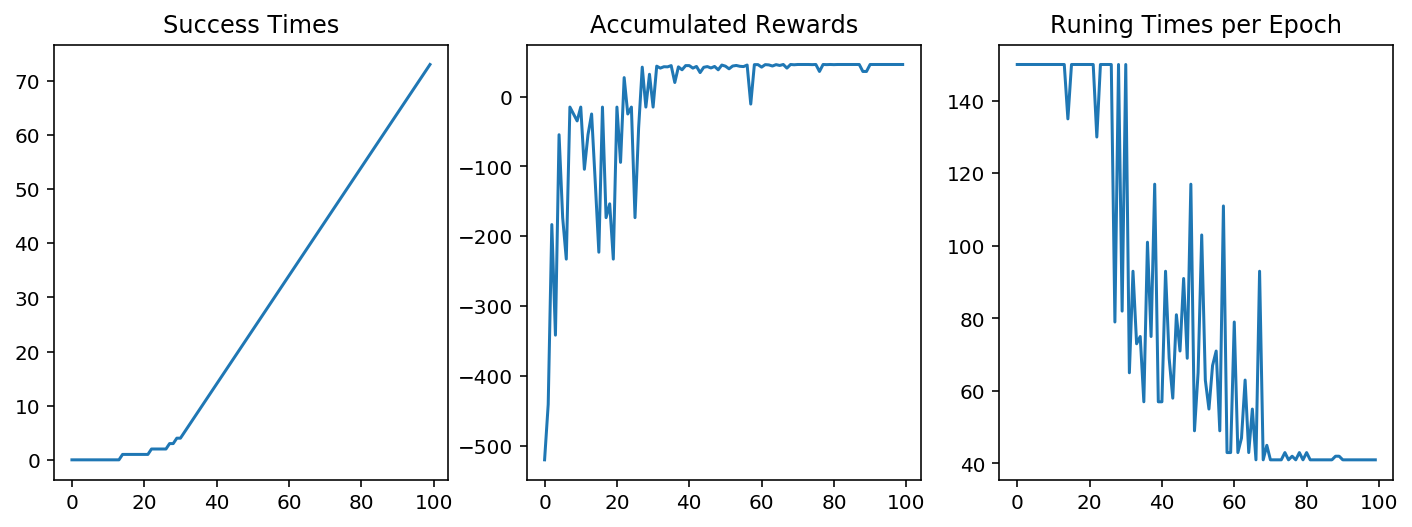

no explicit random explore at the beginning


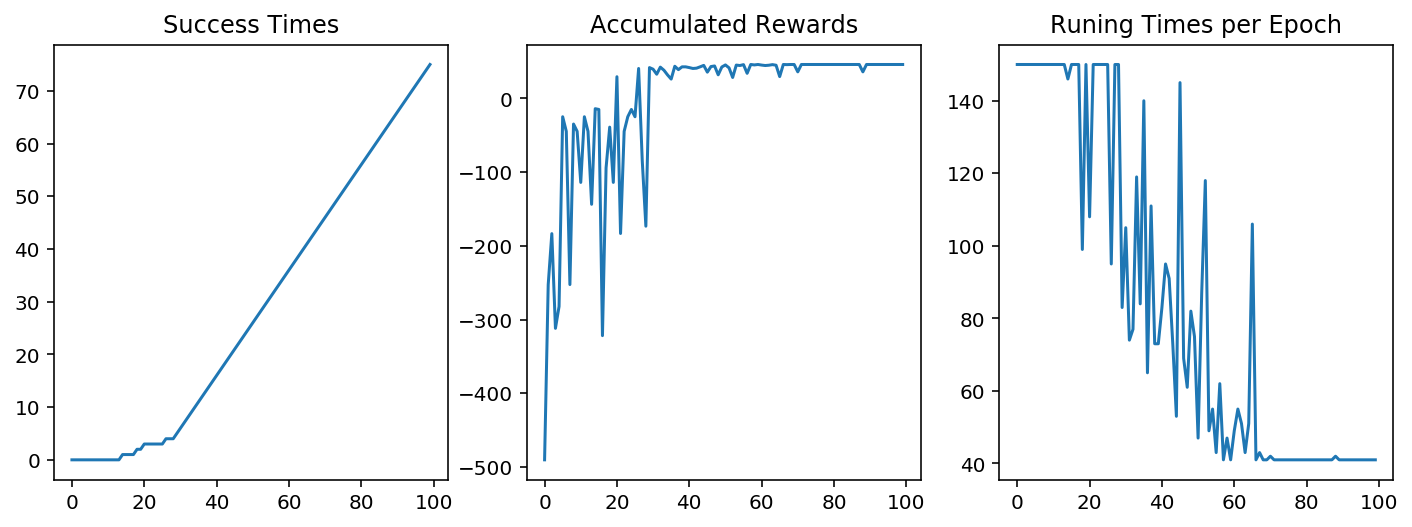

5 times explicit random explore at the beginning


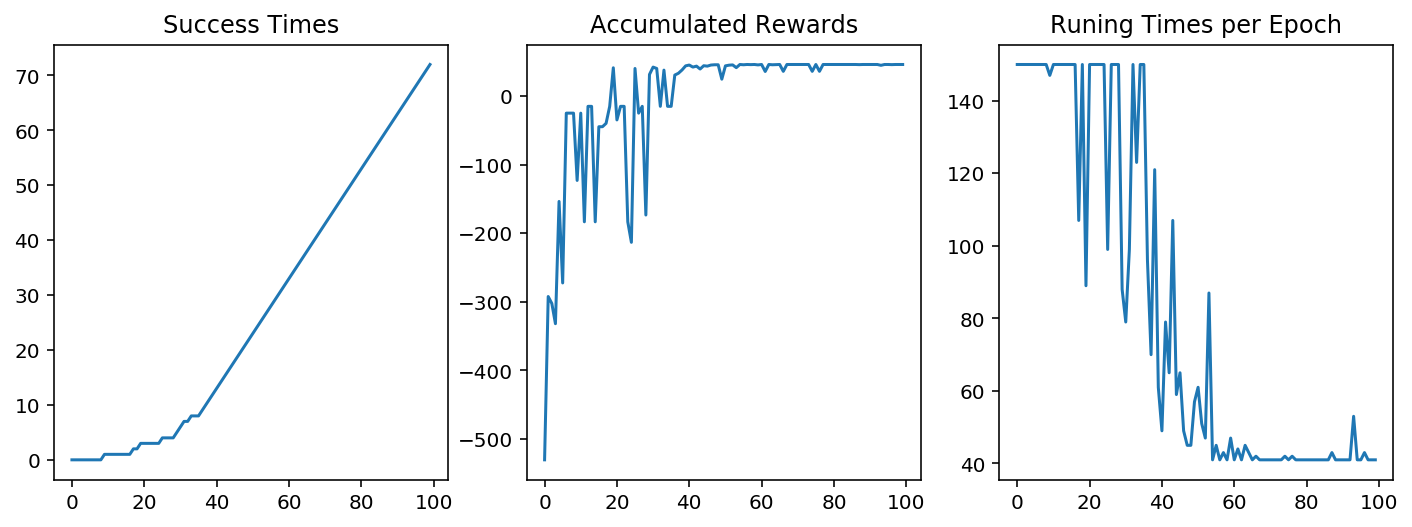

10 times explicit random explore at the beginning


In [21]:
runner_alpha_full_1.plot_results()
print('no explicit random explore at the beginning')
runner_alpha_full_1_explore_5.plot_results()
print('5 times explicit random explore at the beginning')
runner_alpha_full_1_explore_10.plot_results()
print('10 times explicit random explore at the beginning')

In [22]:
print(len(r_alpha_full_1_explore_10.Qtable.keys()))
print(len(r_alpha_full_1_explore_5.Qtable.keys()))
print(len(r_alpha_full_1.Qtable.keys()))

161
163
162


## Gamma 值的调整

In [23]:
r_alpha_full_1_gamma_05 = Robot(g,alpha=1.0, epsilon0=epsilon0, gamma=0.5)
r_alpha_full_1_gamma_05.set_status(learning=True)
runner_alpha_full_1_gamma_05 = Runner(r_alpha_full_1_gamma_05, g)
runner_alpha_full_1_gamma_05.run_training(epoch, display_direction=True)

r_alpha_full_1_gamma_02 = Robot(g,alpha=1.0, epsilon0=epsilon0, gamma=0.2)
r_alpha_full_1_gamma_02.set_status(learning=True)
runner_alpha_full_1_gamma_02 = Runner(r_alpha_full_1_gamma_02, g)
runner_alpha_full_1_gamma_02.run_training(epoch, display_direction=True)

r_alpha_full_1_gamma_005 = Robot(g,alpha=1.0, epsilon0=epsilon0, gamma=0.05)
r_alpha_full_1_gamma_005.set_status(learning=True)
runner_alpha_full_1_gamma_005 = Runner(r_alpha_full_1_gamma_005, g)
runner_alpha_full_1_gamma_005.run_training(epoch, display_direction=True)

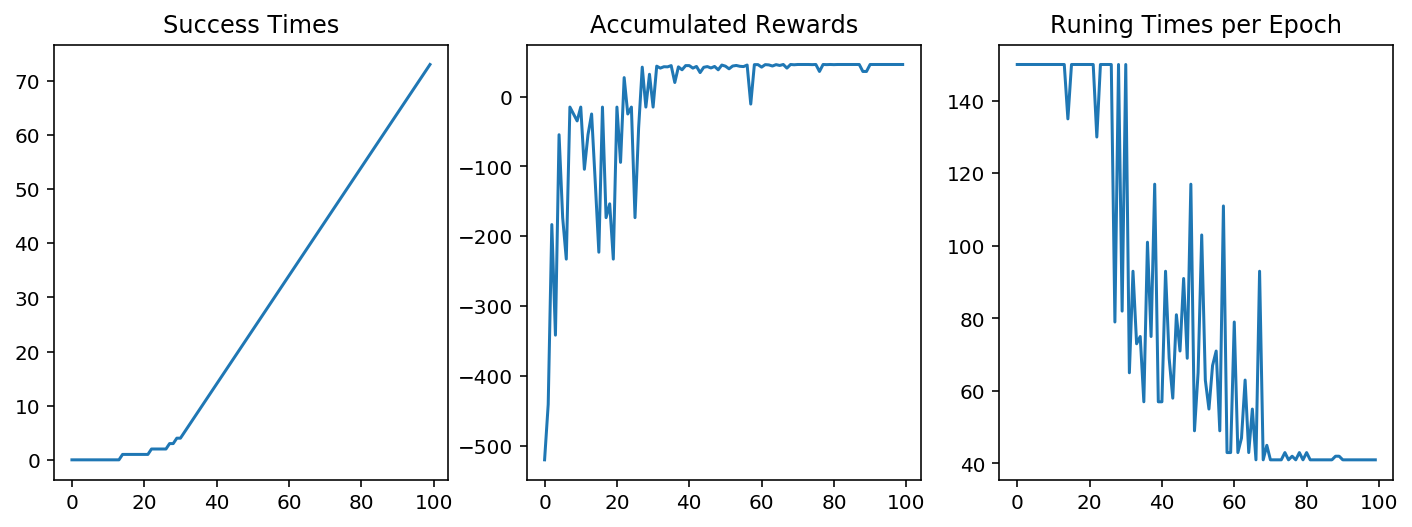

gamma = 0.9


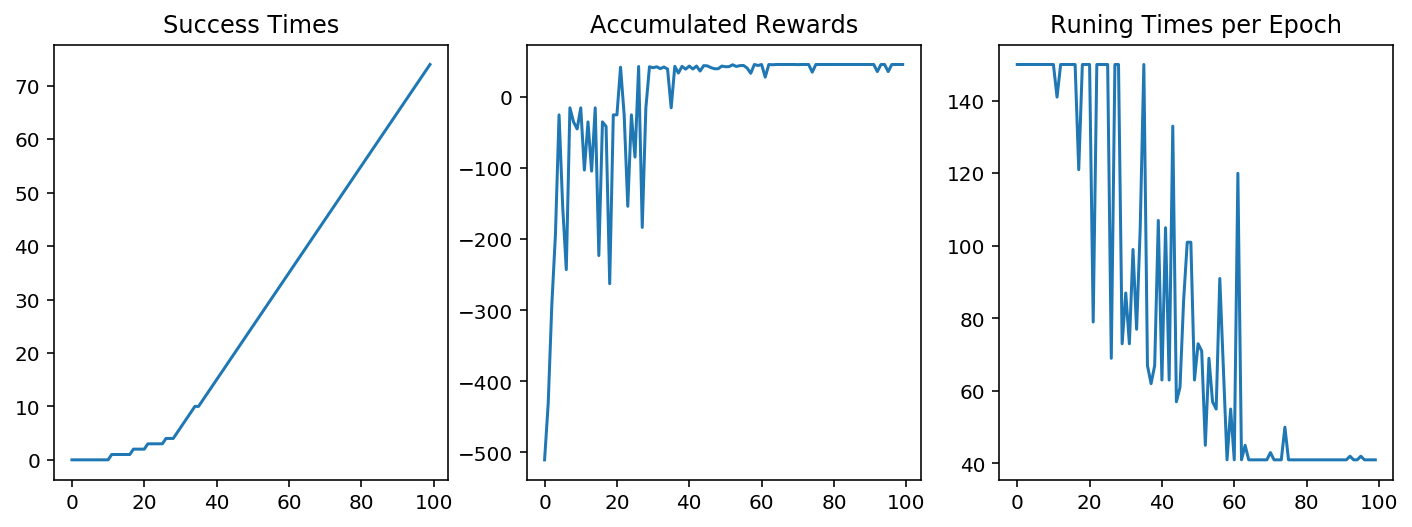

gamma = 0.5


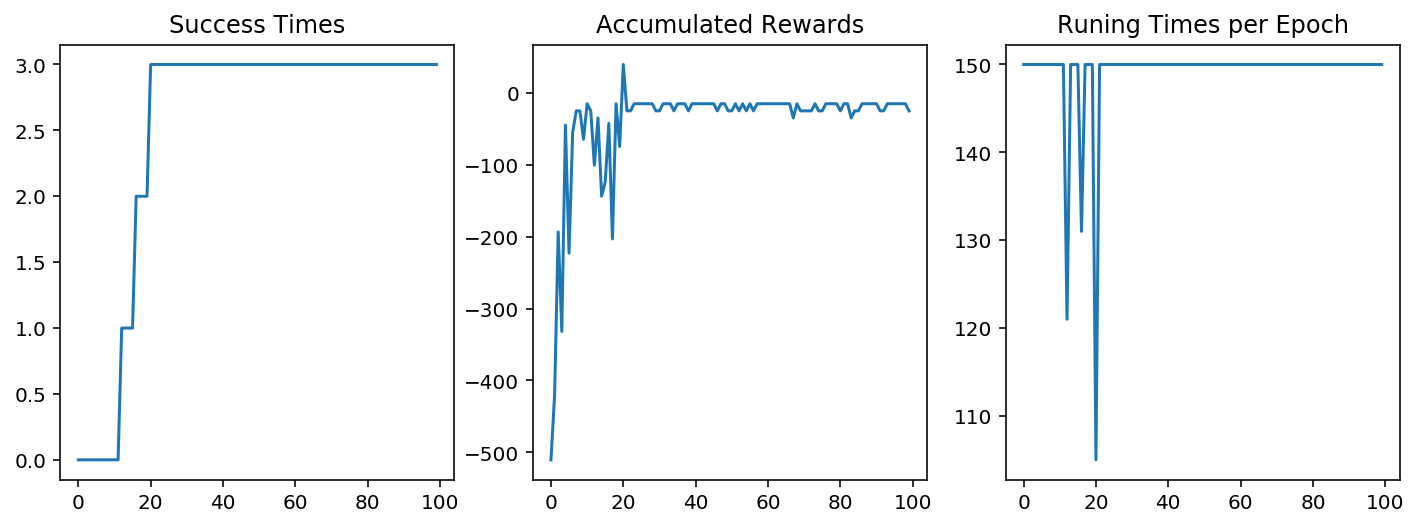

gamma = 0.2


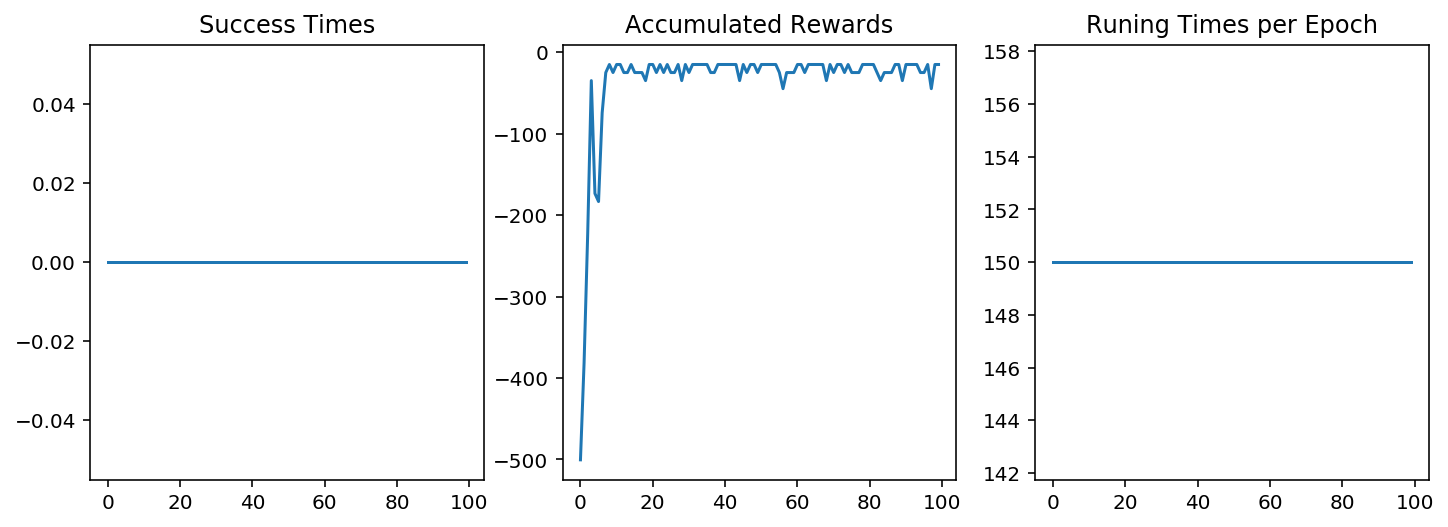

gamma = 0.05


In [24]:
runner_alpha_full_1.plot_results()
print('gamma = 0.9')
runner_alpha_full_1_gamma_05.plot_results()
print('gamma = 0.5')
runner_alpha_full_1_gamma_02.plot_results()
print('gamma = 0.2')
runner_alpha_full_1_gamma_005.plot_results()
print('gamma = 0.05')

(回答区)
参数alpha和参数epsilon对训练结果有很大的影响，需要做仔细的试验调整。

在上面的四个图中，在固定epoch = 100, epsilon0 = 0.5, gamma = 0.9的情况下对alpha = 1, 0.95,0.85,0.7, 0.2, 0.02进行测试。一个非常有趣的现象是在alpha=1时取到最好的成绩，agent很快成功抵达终点，Accumulated Rewards和Running Times Per Epoch很快收敛。Accumulated Rewards 在alpha=0.95, 0.85, 0.7 也很快收敛，但收敛速度随alpha的增大而快。课程中曾讲到，避免将值设的太大，太大的值会阻止算法收敛于最优解，但此处，alpha=1时机器人很快找到了最优解。

我同时对迷宫的大小以及陷阱的数量进行了尝试，来检验一下alpha=1时是否在不同的迷宫的具有通用性，观察到的结果，alpha=1时agent最快敛,在试验中具有通用性。

接下来对两种epsilon的衰减策略进行了测试，这两种衰减策略分别为
- self.epsilon = self.epsilon0 / ( 1 + self.t) 
- self.epsilon = self.epsilon0 / ( 1 + math.sqrt(self.t))
第一种衰减快，第二种衰减比较平缓。我比较倾向于使用第二种衰减策略，我认为在处理大数据量时会体现出优势。在本次实验中，两种衰减策略的比较一致。

接一来，我对epsilon0值进行调整，由于分母 （1 + self.t 或  1 + math.sqrt(self.t))变化带来的影响远大于epsilon0的变化对结果的影响，观察到的结果显示，epsilon0 = 1 和 epsilon0 = 0.5对Agent的影响不大。

在mentor的提示下，我决定尝试一下在初始阶段多进行探索。通过观察Agent的多次行进路线及Q值（有些state并没有出现在Q值中），可以发现Agent对某些区域的探索不够，尤其对迷宫的左下方区域，上述两种epsilon的衰减无法给予Agent充足的探索机会。由于缺乏相关数学衰减函数的足够了解（比如利用进行衰减），我决定引入一个explicit的探索次数explicit_exploration_count在Agent最初适应环境时进行限定次数一的随机探索。实验结果比较有意思，explicit_exploration_count对Success Times 以及Accumulated Rewards没有明显影响，但在Running Times per Epoch的收敛阶段显示更为自然（在explicit_exploration_count= 10时），这表明前期的多次探索为后期的exploitation做了充分的铺垫。由打印出来的Qtable发现，增加exploration的次数，Agent探索到了更多的station space, （在本次结果中没有发现这种现象，由于受初始环境的影响）这将有助于发现最优解而不是停留在次优解。

对gamma值的试验表明，gamma值对训练结果有很大的影响，在gamma值为0.2以下时Agent没有找到最优策略，表明了终点处的正奖励不能够“扩散”到周围。机器人无法学习到一个到达终点的策略


---

**问题 9：** 请将如下的文件打包，提交文件给审阅者。

- `robot.py`
- `robot_maze.ipynb`
- 由 `robot_maze.ipynb` 导出的 `robot_maze.html`